In [4]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.69 langgraph==0.5.3 langchain-openai==0.3.28 langchain-experimental==0.3.4 langgraph-supervisor==0.0.27


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)
        
        if not results:
            return "No results found on Wikipedia."
        
        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."], 
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """
    
    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."
    
    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date
    
    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days
    
    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."
    
    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [6]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent
research_agent = create_react_agent(
    llm,
    tools=[wikipedia_tool, stock_data_tool],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, including looking-up factual information and stock data. DO NOT write any code.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="researcher"
)

# Analyst agent
analyst_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=(
        "You are an agent that can run arbitrary Python code.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with tasks that require running code to produce an output.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="analyst"
)

In [7]:
from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

supervisor = create_supervisor(
    model=llm,
    agents=[analyst_agent, research_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research and data collection tasks to this agent\n"
        "- an analyst agent. Assign the creation of visualizations via code to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(checkpointer=checkpointer)

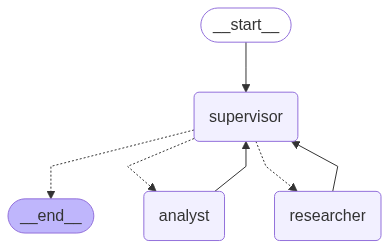

In [8]:
# Visualize your graph
supervisor

Update from node supervisor:


================================ Human Message =================================

Who is Apple's CEO?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researcher (call_tiJLCJoyOVXJGHobXHLl3Gz0)
 Call ID: call_tiJLCJoyOVXJGHobXHLl3Gz0
  Args:
================================= Tool Message =================================
Name: transfer_to_researcher

Successfully transferred to researcher
================================== Ai Message ==================================
Name: researcher
Tool Calls:
  wikipedia_tool (call_M6OxBBFPVpjwYj15OSpAv5U4)
 Call ID: call_M6OxBBFPVpjwYj15OSpAv5U4
  Args:
    query: Apple Inc. CEO
================================= Tool Message =================================
Name: wikipedia_tool

Successfully executed:
Wikipedia summary: Timothy Donald Cook (born November 1, 1960) is an American business executive who is the current chief executive officer of 

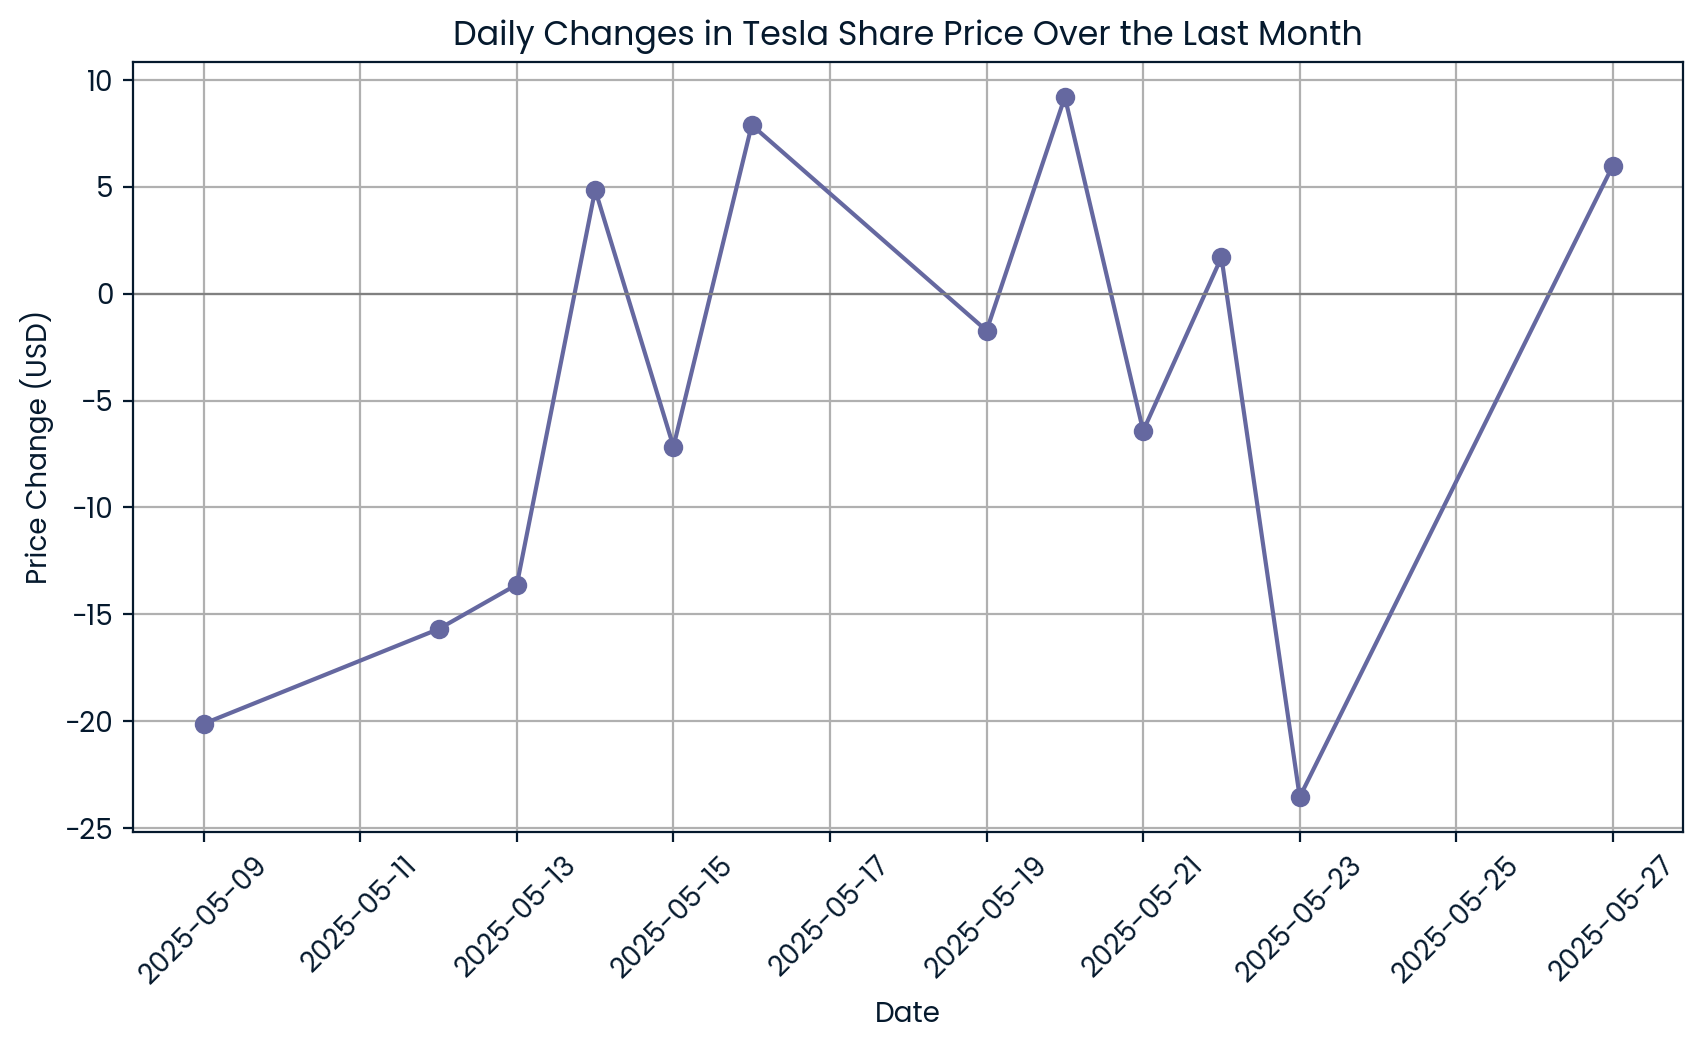

Update from node analyst:


================================ Human Message =================================

Who is Apple's CEO?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researcher (call_tiJLCJoyOVXJGHobXHLl3Gz0)
 Call ID: call_tiJLCJoyOVXJGHobXHLl3Gz0
  Args:
================================= Tool Message =================================
Name: transfer_to_researcher

Successfully transferred to researcher
================================== Ai Message ==================================
Name: researcher
Tool Calls:
  wikipedia_tool (call_M6OxBBFPVpjwYj15OSpAv5U4)
 Call ID: call_M6OxBBFPVpjwYj15OSpAv5U4
  Args:
    query: Apple Inc. CEO
================================= Tool Message =================================
Name: wikipedia_tool

Successfully executed:
Wikipedia summary: Timothy Donald Cook (born November 1, 1960) is an American business executive who is the current chief executive officer of App

In [11]:
from course_helper_functions import pretty_print_messages

for chunk in supervisor.stream(
    {"messages": [{"role": "user", "content": "Has Tesla's share price increased over the last month? plot the daily changes over the last month."}]}, config
):
    pretty_print_messages(chunk)